## LeNet
#### 动手学深度学习 —— LeNet
#### 使用 Pytorch 实现——yujia

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from IPython import display
import random
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import pandas as pd
from d2l import torch as d2l

#### 数据集

In [2]:
train_set = torchvision.datasets.FashionMNIST(
    root='../Dataset', #数据集下载后保存到本地的地址
    train=True, #是否为训练数据集
    download=True,  #是否下载，如果是第一次则需要下载
    transform=transforms.ToTensor())#转为张量

test_set = torchvision.datasets.FashionMNIST(
    root='../Dataset', 
    train=False, 
    download=True, 
    transform=transforms.ToTensor())

In [3]:
batch_size = 64
num_workers = 1
classes = train_set.classes

train_iter = DataLoader(
    dataset = train_set,
    batch_size = batch_size,
    shuffle = True,
    num_workers = num_workers,
    drop_last = True
)

test_iter = DataLoader(
    dataset = test_set,
    batch_size = batch_size,
    shuffle = True,
    num_workers = num_workers,
    drop_last = True
)

#### LeNet 网络

In [4]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.lenet = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, padding=2),
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(16*5*5, 120),
            nn.Sigmoid(),
            nn.Linear(120, 84),
            nn.Sigmoid(),
            nn.Linear(84, 10)
        )
    def forward(self, x):
        y = self.lenet(x)
        return y
model = LeNet()
model

LeNet(
  (lenet): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Sigmoid()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Sigmoid()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=400, out_features=120, bias=True)
    (8): Sigmoid()
    (9): Linear(in_features=120, out_features=84, bias=True)
    (10): Sigmoid()
    (11): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [5]:
print(d2l.try_gpu())

cuda:0


#### 几个函数的意义：
1、 isinstance(x, type): 用于判断一个对象的变量类型，判断 x 是否为 type 类型   
2、 d2l.Accumulator(n) : 开辟一个包含 n 个空间的累加器，这里的作用就是用于累加每个batch的 y_hat = y 的数量和每个batch的总数，方便计算acc  
3、 d2l.accuracy(y_hat, y) : 用于计算y_hat = y 的数量，具体可以查看源码，d2l.accuracy??

In [24]:
def evaluate_accuracy_gpu(model, data_iter, device=None):
    if isinstance(model, nn.Module):
        model.eval()
        if not device:
            device = next(iter(model.parameters())).device
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(model(X), y), y.numel())
    return metric[0] / metric[1]

In [25]:
def train(model, train_iter, test_iter, num_epochs, lr, device):
    def init_weight(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    model.apply(init_weight)
    print('training on', device)
    model.to(device)
    opt = torch.optim.SGD(model.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], legend=['train_loss', 'train_acc', 'test_acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        model.train()
        for step, (X, y) in enumerate(train_iter):
            timer.start()
            opt.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = model(X)
            l = loss(y_hat, y)
            l.backward()
            opt.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (step + 1) % (num_batches // 5) == 0 or step == num_batches-1:
                animator.add(epoch + (step+1) / num_batches, (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(model, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l: .3f}, train_acc {train_acc: .3f},'
            f'test_acc {test_acc: .3f}')
    print(f'{metric[2] * num_epochs / timer.sum(): .1f} examples/sec '
            f'on {str(device)}')

loss  0.343, train_acc  0.870,test_acc  0.867
 21000.5 examples/secon cuda:0


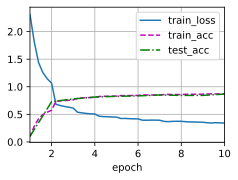

In [26]:
lr, num_epochs = 0.9, 10
train(model, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())